In [1]:
# General

import numpy as np
import pandas as pd
import re
import os
import pickle
import random

# EDA

import matplotlib.pyplot as plt
import plotly.express as px

# NLP
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# ML
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# Data Manipulation using TF-IDF Vectorizer

In [9]:
store = pd.HDFStore('store.h5')
data = store['data_stemmed']
data.head()

,class,message,no_of_chars,no_of_words,no_of_sentences,Spam,corpus
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,0,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,0,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,1,free entri wkli comp win fa cup final tkt st m...
3,ham,U dun say so early hor... U c already then say...,49,13,1,0,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,0,nah think goe usf live around though


In [10]:
tfidf = TfidfVectorizer(max_features = 3000)
X = tfidf.fit_transform(data['corpus']).toarray()
Y = data['Spam'].values

# Train-Test Split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 30)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(4457, 3000) (1115, 3000) (4457,) (1115,)


# Eval Metrics

In [14]:
def eval_metrics(classifier, y_train, yp_train, y_test, yp_test):
    
    print(f"\n-----------------------------{classifier}-----------------------------\n")
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
          
    cm_test = confusion_matrix(y_test, yp_test)
    t2 = ConfusionMatrixDisplay(cm_test)
    s2 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Specificity on Test Data: ", s2)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()


-----------------------------Naive Bayes Classifier-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3855
           1       1.00      0.88      0.94       602

    accuracy                           0.98      4457
   macro avg       0.99      0.94      0.96      4457
weighted avg       0.98      0.98      0.98      4457

--------------------------------------------------------------------------
Specificity on Train Data:  0.9995
Accuracy on Train Data:  0.9838
F1 Score on Train Data:  0.9366
--------------------------------------------------------------------------

Classification Report for Test Data

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       970
           1       0.98      0.79      0.87       145

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93    

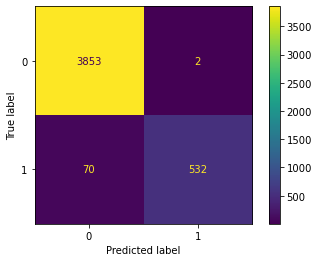

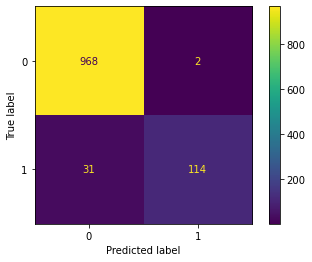

In [13]:
nb = MultinomialNB()
nb.fit(x_train, y_train)

yp_train = nb.predict(x_train)
yp_test = nb.predict(x_test)

eval_metrics("Naive Bayes Classifier", y_train, yp_train, y_test, yp_test)

In [15]:
pickle.dump(nb, open('nb_model.pkl', 'wb')) # wb: open for writing and open and binary mode
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))